In [ ]:
# ignore warnings

import warnings
warnings.filterwarnings("ignore")

Installing Dependencies

In [ ]:
! pip3 install torch torchvision
! pip install datasets
! pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

Load dataset

In [ ]:
from datasets import load_dataset
multi_news = load_dataset("multi_news", split="test")

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Dataset multi_news downloaded and prepared to /root/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72. Subsequent calls will reuse this data.


View Data

In [ ]:
data = multi_news.to_pandas()
data.to_csv('dataframe.csv', index=False)

In [ ]:
multi_news_test_train = multi_news[:5522]
multi_news_validation = multi_news[-100:]

In [ ]:
from datasets import Dataset
multi_news_test_train = Dataset.from_dict(multi_news_test_train)

Train test split (80:20 ratio respectively)

In [ ]:
multi_news_test_train = multi_news_test_train.train_test_split(test_size=0.2)

Tokenizing Training and testing sets

In [ ]:
! pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 130.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [ ]:
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text=examples["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_multi_news_test_train = multi_news_test_train.map(preprocess_function, batched=True)

Map:   0%|          | 0/4417 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Model Loading

In [ ]:
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model='t5-small')
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

Defining Hyperparameters

In [ ]:
training_args = Seq2SeqTrainingArguments(
output_dir="./results",
evaluation_strategy="epoch",
learning_rate=2e-5,
per_device_train_batch_size=10,
per_device_eval_batch_size=10,
weight_decay=0.01,
save_total_limit=3,
num_train_epochs=25,
fp16=False,
)


Initializing Trainer

In [ ]:
trainer = Seq2SeqTrainer(
model=model,
args=training_args,
train_dataset=tokenized_multi_news_test_train["train"],
eval_dataset=tokenized_multi_news_test_train["test"],
tokenizer=tokenizer,
data_collator=data_collator,
)


Train the Text Summarization Model 

In [ ]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download('/content/model2.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil

source_path = '/content/dataframe_final_results_25.csv'
destination_path = '/content/drive/MyDrive/final_data'

shutil.copy(source_path, destination_path)

'/content/drive/MyDrive/final_data'

Evaluate model on a single document

In [ ]:
document = " Tesla (TSLA.O) shares jumped 6% on Friday on expectations that its electric-vehicle charging system would become an industry standard after General Motors (GM.N) joined cross-town rival Ford (F.N) in agreeing to use the Tesla Supercharger network. The Elon Musk-led automaker was on course for its eleventh straight session of gains, which would mark its longest winning streak in 2-1/2 years. Tesla was also among the most traded stock across U.S. exchanges.Already the world's most valuable automaker, Tesla was set to increase its market capitalization by more than $30 billion to about $780 billion. Shares of General Motors, whose market capitalization is much lower at $49.8 billion but sells millions more vehicles annually, rose nearly 5%. The rare partnership among three of the biggest U.S. automakers ensures that nearly 70% of the country's EV market will have access to Tesla's North American Charging Standard (NACS).That will put pressure on other companies to upgrade their networks to work with Tesla's at a time when many lag in customer service and lack the funds to make such a commitment. Shares of charging companies such as ChargePoint Holdings Inc (CHPT.N), EVgo Inc (EVGO.O) and Blink Charging Co (BLNK.O) were down between 3.0% and 10%. It's a huge boost for Tesla's charging business, said Consumer Reports senior policy analyst Chris Harto. They are like to cement themselves as the number one charging network in the country. It definitely could become a big profit center for them going forward. Wedbush Securities estimated Ford and GM combined could add $3 billion to services EV charging revenue for Tesla over the next few years. The brokerage also raised its price target on Tesla shares to $300, which is nearly 30% above their last close.The stock has a forward 12-month price-to-earnings ratio of 60.46, among the highest in the S&P 500 index (.SPX) and above GM's 5.29 and 7.94 for Ford. Tesla's NACS is more widespread and reliable than CCS, or the combined charging system, which the U.S. government has tried to support by setting aside $7.5 billion in federal funds. Many complain that the CCS charging infrastructure is inefficient or sometimes inoperable, leading prospective buyers to fear becoming stranded on the road with nowhere to charge. Greater usage of Tesla Superchargers could, however, create its own problems for the Musk-led company, said Michael Austin, senior research analyst at Guidehouse. There is a risk for Tesla in terms of either making the stations too busy and disappointing Tesla owners or removing that competitive advantage of having exclusive access to the best network, Austin said."


In [ ]:
import torch
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
model.load_state_dict(torch.load('/content/drive/MyDrive/AI MINI PROJECT/model_25_final/pytorch_model.bin'))
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
def predict_summary(document):
  device = model.device
  tokenized = tokenizer([document], truncation =True, padding ='longest',return_tensors='pt')
  tokenized = {k: v.to(device) for k, v in tokenized.items()}
  tokenized_result = model.generate(**tokenized, max_length=128)
  tokenized_result = tokenized_result.to('cpu')
  predicted_summary = tokenizer.decode(tokenized_result[0])
  return predicted_summary

In [ ]:
predicted_summary = predict_summary(document)
predicted_summary

"<pad> – Tesla's charging system will become an industry standard after General Motors (GM.N) joined cross-town rival Ford (F.N) in agreeing to use the Tesla Supercharger network. Tesla shares jumped 6% Friday on expectations that its electric-vehicle charging system would become an industry standard after General Motors (GM.N) joined cross-town rival Ford (F.N) in agreeing to use the Tesla Supercharger network. Tesla's market capitalization is much lower at $49.8 billion but sell millions more vehicles annually,</s>"

Evaluate using Rouge Scores

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a suite of metrics for evaluating the quality of text summaries. It compares a set of reference summaries with a set of generated summaries, and computes a score based on the overlap between the two.

In [ ]:
from rouge import Rouge

def get_rouge_scores(actual_summary, predicted_summary):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, actual_summary)
    return [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']]

In [ ]:
# import validation dataset

import pandas as pd
val_data = multi_news_validation
val_data = pd.DataFrame(val_data)
val_data
val_data.to_csv('dataframe_validation.csv', index=False)

In [ ]:
# rouge score of validation data

from tqdm import tqdm

rouge1_scores = []
rouge2_scores = []
rougel_scores = []

pred_summary_list = []

for i in tqdm(range(len(val_data))):
    doc = val_data.loc[i]['document']
    pred_summary = predict_summary(doc)
    human_summary = val_data.loc[i]['summary']

    # Remove extra tokens from generated summary
    pred_summary = pred_summary.replace("<extra_id_0>", "").replace("<extra_id_1>", "").replace("<extra_id_2>", "").replace("<extra_id_3>", "")
    pred_summary = pred_summary.replace("<extra_id_4>", "").replace("<extra_id_5>", "").replace("<extra_id_6>", "")
    
    # Refine the summary further if needed
    refined_summary = pred_summary.strip()

    score = get_rouge_scores(human_summary, refined_summary)

    rouge1_scores.append(score[0])
    rouge2_scores.append(score[1])
    rougel_scores.append(score[2])

    pred_summary_list.append(refined_summary)

val_data["pred_summary"] = pred_summary_list
val_data['rouge1'] = rouge1_scores
val_data['rouge2'] = rouge2_scores
val_data['rougel'] = rougel_scores

val_data


100%|██████████| 100/100 [05:59<00:00,  3.59s/it]


,document,summary,pred_summary,rouge1,rouge2,rougel
0,Get daily updates directly to your inbox + Sub...,"– In medieval times, pilgrims flocked to Engla...",<pad> – A medieval well that was once believed...,0.305221,0.062323,0.216867
1,"Michael Phelps, the most decorated athlete in ...","– ""King of the Olympic Rings"" Michael Phelps a...",<pad> – Michael Phelps is the most decorated a...,0.204255,0.048485,0.204255
2,NEW YORK — A 27-year-old man detonated a crude...,– The man accused of detonating a bomb in a su...,<pad> – A 27-year-old man detonated a crude pi...,0.319328,0.093168,0.226891
3,Consumers screamed for it. Verizon answered. L...,"– Verizon yesterday unveiled its new ""Share Ev...",<pad> – The new shared data plan is a new one....,0.235294,0.094488,0.235294
4,Two bills that would increase restrictions on ...,– Abortion opponents in North Dakota have one-...,<pad> – A Senate bill that would increase rest...,0.200957,0.054983,0.191388
...,...,...,...,...,...,...
95,Tweet with a location \n \n You can add locati...,– The traditional end-of-summit group photo at...,<pad> – President Trump is cutting short his f...,0.295203,0.126649,0.280443
96,Loic Venance/AFP/Getty Images \n \n The awards...,– Sofia Coppola scored a historic victory at t...,<pad> – Sofia Coppola won the Palme d'Or for B...,0.298969,0.142322,0.288660
97,(CNN) A federal criminal investigation into a ...,– The duck boat sinking that killed 17 on a Mi...,<pad> – The captains of two Ride the Ducks boa...,0.334694,0.092879,0.236735
98,An archive of the public statements deleted by...,– Note to tweeting politicians: Watch what you...,<pad> – An archive of the public statements de...,0.133333,0.000000,0.121212


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

val_data.to_csv('dataframe_final_results_25.csv', index=False)

In [ ]:
# average rouge 1
val_data['rouge1'].mean()

0.2545118666844953

In [ ]:
# average rouge 2
val_data['rouge2'].mean()

0.07968817357218895

In [ ]:
# average rouge l
val_data['rougel'].mean()

0.23149624759922008

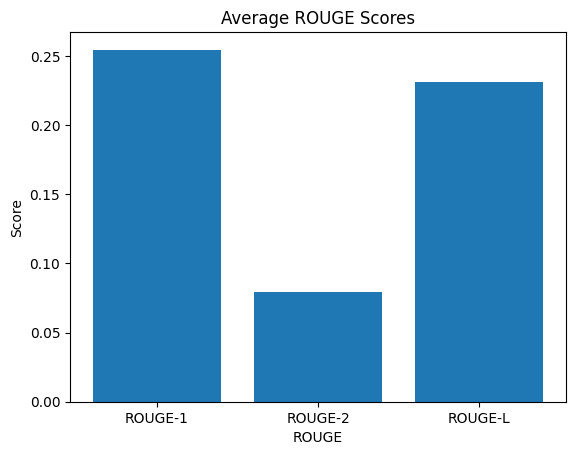

In [ ]:
import matplotlib.pyplot as plt
avg_rouge1 = val_data['rouge1'].mean()
avg_rouge2 = val_data['rouge2'].mean()
avg_rougel = val_data['rougel'].mean()

# Create a list of average scores
avg_scores = [avg_rouge1, avg_rouge2, avg_rougel]

# Create a list of ROUGE names
rouge_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Create a bar plot
plt.bar(rouge_names, avg_scores)
plt.xlabel('ROUGE')
plt.ylabel('Score')
plt.title('Average ROUGE Scores')
plt.show()